# EXPLAINABLE AI 

## PRE

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cof import COF
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.svm import SVC

import pydotplus
from sklearn import tree
from IPython.display import Image

In [4]:
def training_pulito(df_train_csv):
    selected = ['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
 'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
 'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
 'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
 'sc_skew_w4','stft_sum_w4','stft_kur_w4']

    df_selected = df_train_csv[selected]
    emotion_train = df_train_csv['emotion']
    
    df_train_sel, df_test_sel, emotion_train_train, emotion_train_test = train_test_split(
        df_selected, emotion_train, test_size=0.3, random_state=0)
        
    ## outlier detection 
    # normalizzazione
    sc = StandardScaler()
    df_norm = sc.fit_transform(df_selected)  # normalizzato intero 

    # sc.fit(df_train_sel)
    # df_train_sel_norm=sc.transform(df_train_sel)  # normalizzato a pezzi
    # df_test_sel_norm=sc.transform(df_test_sel)

    # LOF
    clf=LocalOutlierFactor(n_neighbors=190)
    lof_outliers = clf.fit_predict(df_norm) 
    out_lof=np.where(lof_outliers==-1)

    # COF 
    cof_=COF(n_neighbors=20)
    cof_outliers = cof_.fit_predict(df_norm) 
    out_cof=np.where(cof_outliers==1)

    # ABOD
    clf = ABOD(0.02)  # contamination = 0.02
    clf.fit(df_norm)
    out_abod = np.where(clf.labels_ == 1)

    # ISOLATION FOREST 
    clf = IsolationForest(random_state=0 )
    clf.fit(df_selected)
    clf.predict(df_selected)
    if_outliers = clf.predict(df_selected)
    if_outliers #For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model.
    #-1 sono outliers 
    out_if=np.where(if_outliers==-1)

    #qua trasformiamo tutto il lista per applicare la funzione counter
    out_lof_list = (out_lof[0]).tolist()
    out_cof_list = (out_cof[0]).tolist()
    out_if_list = (out_if[0]).tolist()
    out_abod_list = (out_abod[0]).tolist()

    outliers_lista = out_lof_list + out_cof_list + out_if_list + out_abod_list # lista di tutte le osservazioni outliers
    diz = Counter(outliers_lista) # contiamo quante volte si ripetono gli outliers nei 4 metodi 
    mega_outliers=[] # lista che riempiamo con gli outliers che si ripetono per almeno 3 volte 
    for el in diz:
        if diz[el]>=3:
            mega_outliers.append(el)

    selected_and_cat=['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']
    
    
    df_final_cat = df_train_csv[selected_and_cat]

    df_final = df_selected.drop(mega_outliers)   #rimozione dei mega outliers dal dataset 
    df_final_cat = df_final_cat.drop(mega_outliers)

    # df_final è numerico
    #df_final_cat è intero sia cat che num 
    return df_final, df_final_cat

In [5]:
# questa funzione ritorna il test set con le stesse colonne selezionate nel training set
def test_pulito(df):
    selected = ['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
   'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
   'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
   'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
   'sc_skew_w4','stft_sum_w4','stft_kur_w4']
   
    selected_and_cat=['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']
    
    df_test_numerico = df[selected]
    df_test_num_cat = df[selected_and_cat]
    
    return df_test_numerico, df_test_num_cat

In [6]:
df_train_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TRAIN.csv')
df_test_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TEST.csv')

# solo numerici, se si ha bisogno sia di features numeriche che categoriche usare :  training_pulito(df_train_csv)[1]
df_train = training_pulito(df_train_csv)[0]
df_test = test_pulito(df_test_csv)[0]

X_train = df_train.values
X_test = df_test.values
y_train = training_pulito(df_train_csv)[1]['emotion']
y_test = test_pulito(df_test_csv)[1]['emotion']

# normalizzazione

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated


## TREPAN (approssimazione di TREPAN in realtà), con black box SVM 

In [18]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [19]:
bb = SVC(gamma = 0.00191, kernel = 'rbf', C = 31, class_weight = 'balanced', probability=True) # best SVM 
bb.fit(X_train, y_train)

SVC(C=31, class_weight='balanced', gamma=0.00191, probability=True)

In [20]:
# just calling the predict or the predict proba of the bb
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [21]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred, average='macro'))

Accuracy 0.484
F1-measure 0.472


In [22]:
#è un'approssimazione di TREPAN (perchè TreeSurrogate potrebbe non funzionare)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

y_pred_train = bb_predict(X_train)  # train! 
# # IL MODELLO E' TRAINATO SULLA PREDIZIONE DELLA BB !!!!

In [23]:
explainer = DecisionTreeClassifier(max_depth=4)  #max_depth = 4 perchè poi lo voglio spiegare - sarà il gloabal explainer della mia bb svm
explainer.fit(X_train, y_pred_train)   # uso come target variable the prediction on the training, NON the ground truth!

DecisionTreeClassifier(max_depth=4)

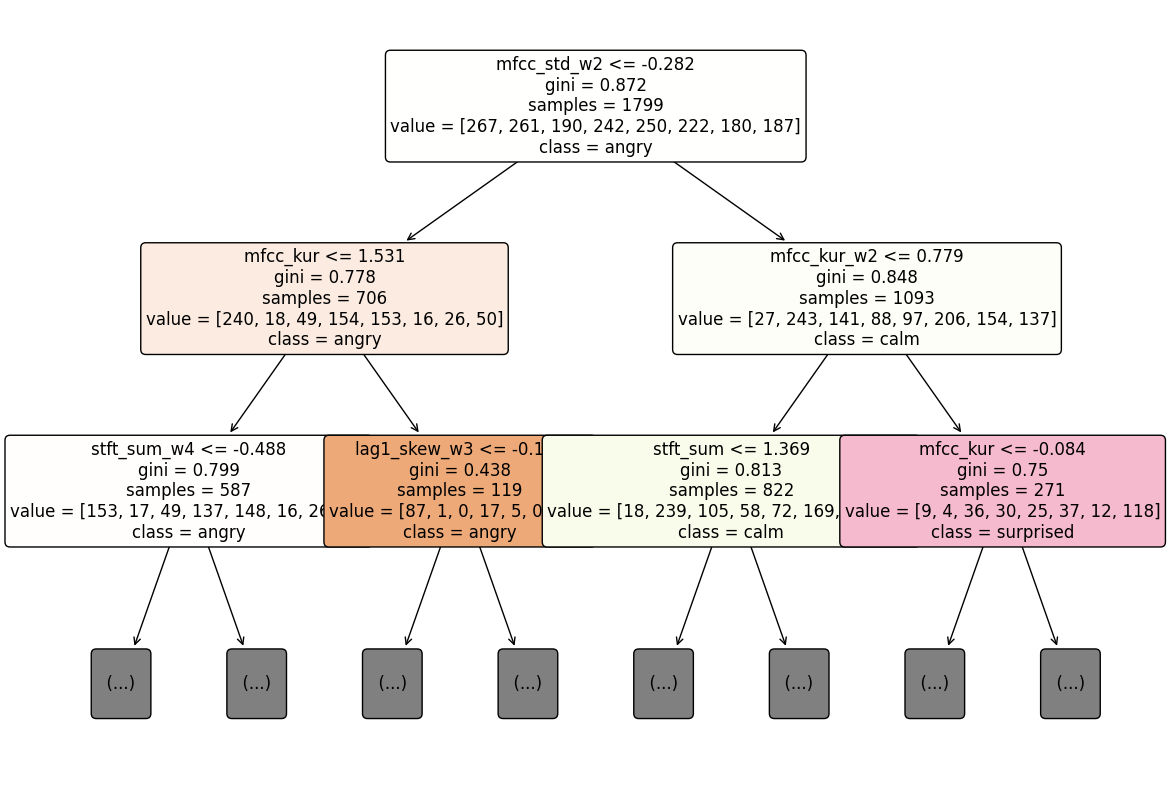

In [13]:
feature_names = ['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
 'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
 'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
 'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
 'sc_skew_w4','stft_sum_w4','stft_kur_w4']

plt.figure(figsize=(14, 10))
plot_tree(explainer, 
          feature_names=feature_names, 
          class_names=list(bb.classes_), 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(explainer, 
                   feature_names=feature_names,  
                   class_names=list(bb.classes_),
                   filled=True,
                   max_depth=2,
                   fontsize=12)
fig.savefig("decision_tree.png")

In [ ]:
'''import dtreeviz
viz = dtreeviz.model(explainer, X_train, y_pred_train,
                target_name="emotion",
                feature_names=feature_names,
                class_names=list(bb.classes_))

v = viz.view() '''    # render as SVG into internal object 

# QUESTO PLOT è SU UN ALTRO NOTEBOOK FATTO SU COLAB PERCHE' QUA IN LOCALE NON MI FUNZIONAVA 

## LIME (SOLO BOZZA - NO PROGETTO FINALE)

In [ ]:
pip install lime

In [168]:
from lime.lime_tabular import LimeTabularExplainer


In [164]:
x = X_test[623] # un record a caso del test 

In [165]:
class_names = list(bb.classes_) 

In [166]:
bb_outcome = bb_predict(x.reshape(1, -1))[0]   #bb applicata solo sul record che voglio spiegare 
 #bb_outcome_str = class_names[bb_outcome]

print('bb(x) = { %s }' % bb_outcome)   # bb(x) = { fearful }  
print('')

bb(x) = { angry }



In [169]:
lime_explainer = LimeTabularExplainer(X_test,  # assuming we dont have access to the training, come se il bb fosse creato sul training da qualcunaltro e io non ho quel training ho solo il test
                                      feature_names=feature_names,
                                      class_names=class_names, discretize_continuous=False)

In [170]:
exp = lime_explainer.explain_instance(x, bb_predict_proba, labels=[0, 1, 2, 3, 4, 5, 6, 7])  # passo anche bb_predict_proba, perchè lime usa la prdiction probability invece che solo la prediction 

In [171]:
y_test[623]

'fearful'

In [172]:
exp.local_exp  # accessing the internals of the explanation

# feature 13 is the most important with a negative contribution of 0.05050902187987941
# restituisce una spiegazione locale per la previsione del modello su un'istanza di dati specifica.

{0: [(13, 0.05050902187987941),
  (15, -0.042872417117883053),
  (37, -0.03422339087587729),
  (3, -0.03181596753013189),
  (25, 0.03003986646846568),
  (10, -0.027790114105083547),
  (16, 0.026292733497094066),
  (42, 0.02611329232920683),
  (12, 0.025325779903269043),
  (9, -0.019327808380597822)],
 1: [(42, -0.04327669626994355),
  (28, -0.03858273082906647),
  (15, 0.03453181848638128),
  (38, 0.028065155329970892),
  (23, -0.02249574962704546),
  (35, -0.021537101233959077),
  (40, 0.020793867273471493),
  (9, 0.019218475666446685),
  (3, 0.01693137308538702),
  (33, -0.011453442746255142)],
 2: [(33, -0.02862478274854195),
  (42, 0.027775482464108176),
  (23, 0.02744370392890318),
  (40, 0.025800006723981337),
  (22, 0.024874771860785502),
  (13, 0.023264457475964),
  (26, -0.01860184161695982),
  (9, 0.017244403837505525),
  (15, -0.013529497695938385),
  (12, 0.011495602137471287)],
 3: [(33, 0.05105913164646289),
  (23, 0.04161026940602806),
  (22, -0.034808170809826455),
  (3

In [173]:
exp.show_in_notebook()

In [48]:
#ciclo for abbastanza brutto per vedere qual è il primo record su cui il mio modello compie un errore di classificazione 
for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        if y_test[i] == 'happy':
            print(i, 'true:', y_test[i], 'pred:', y_pred[i]) 

# record numero 12 ha classe true: happy ma il mio modello pred: calm

12 true: happy pred: calm
13 true: happy pred: fearful
14 true: happy pred: neutral
16 true: happy pred: disgust
17 true: happy pred: fearful
18 true: happy pred: disgust
19 true: happy pred: disgust
72 true: happy pred: angry
73 true: happy pred: angry
74 true: happy pred: angry
75 true: happy pred: angry
76 true: happy pred: angry
77 true: happy pred: angry
78 true: happy pred: angry
79 true: happy pred: angry
117 true: happy pred: neutral
118 true: happy pred: disgust
119 true: happy pred: neutral
180 true: happy pred: angry
181 true: happy pred: angry
182 true: happy pred: fearful
183 true: happy pred: angry
220 true: happy pred: angry
222 true: happy pred: fearful
223 true: happy pred: angry
224 true: happy pred: angry
225 true: happy pred: angry
226 true: happy pred: fearful
227 true: happy pred: angry
280 true: happy pred: neutral
281 true: happy pred: neutral
282 true: happy pred: neutral
283 true: happy pred: neutral
284 true: happy pred: neutral
324 true: happy pred: disgust


## SHAP --> runno sui centroidi - (SOLO BOZZA - NO PROGETTO FINALE)

In [ ]:
pip install shap

In [35]:
import shap
shap.initjs()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

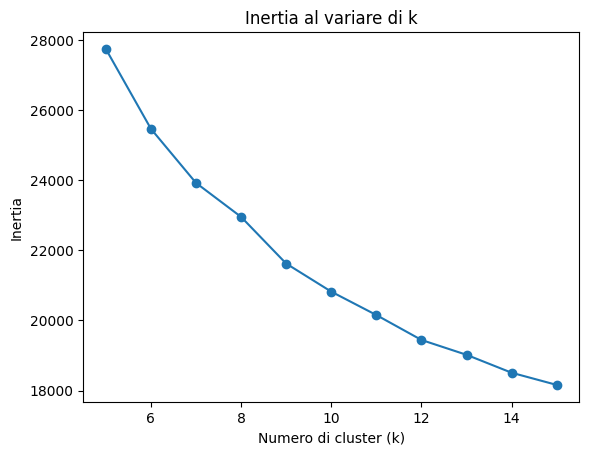

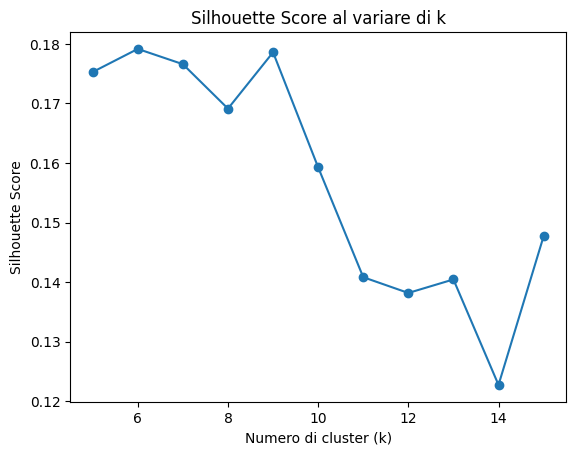

In [55]:
# QUI STO CERCANDO K OTTIMO 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Esecuzione di K-means e calcolo di inertia e silhouette score per valori di k tra 5 e 15
k_values = range(5, 16)
inertia_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_test)
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_test, kmeans.labels_))

# Plotting dell'inertia al variare di k
plt.plot(k_values, inertia_scores, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.title('Inertia al variare di k')
plt.show()

# Plotting della silhouette score al variare di k
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score al variare di k')
plt.show()

In [65]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(X_test)
centroids = kmeans.cluster_centers_

# shap - come guidotti 
f = lambda x: bb_predict_proba(x)[:, 1]
shap_explainerk = shap.KernelExplainer(f, centroids)

shap_values_singlek = shap_explainerk.shap_values(x, nsamples=1000)
shap_values_singlek

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([-0.00239414,  0.00193288, -0.00280249,  0.01131339,  0.        ,
        0.00197111,  0.00199496,  0.        ,  0.00030662, -0.00255255,
        0.00382936, -0.00133459, -0.00775871, -0.00738273, -0.03282777,
       -0.02231041,  0.        , -0.00364701, -0.00646257,  0.00200287,
        0.        ,  0.00901186, -0.0034641 ,  0.00443387,  0.00213206,
        0.00276954,  0.00217355, -0.00602722,  0.00619352, -0.01470974,
        0.00167028, -0.01275756, -0.00639044, -0.01290021, -0.00746955,
        0.00415143,  0.01105402,  0.00112325,  0.01195114, -0.00794956,
       -0.00975381,  0.00706033,  0.0185601 , -0.0013655 ,  0.00366311,
       -0.00388535,  0.01227346,  0.01374032, -0.00776349, -0.00640761,
        0.00356714, -0.01448334, -0.00467036,  0.00051469])

In [66]:
shap.force_plot(shap_explainerk.expected_value, shap_values_singlek, features=x, feature_names=feature_names)

In [ ]:
'''# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(bb.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")'''

In [36]:
''' f = lambda x: bb_predict_proba(x)[:, 1]   # encapsulate the bb predict proba and in this case non voglio the predict proba per tutti ma devo specificare la classe in cui sono interessat 
# --> quello ritornato dal bb per l'istanza che sto cercando di spiegare
med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))   #valore mediano di tutto il dataset, è un'approx per evitare che vengano testate tutte le possibili coalizioni nella function sotto
# non testo tutte le possibile coalitions 

# oppure run kmeans sul dataset con k = 10, o 5
# poi passa i centroidi (nella funzione sotto al posto di med) così 5 different values for features are tested 

shap_explainer = shap.KernelExplainer(f, med) 

shap_values = shap_explainer.shap_values(X_test) 

shap.summary_plot(shap_values, X_test)

shap.plots.waterfall(shap_values[0])

shap.plots.scatter(shap_values, color=shap_values) '''

## Counterfactual Explanations - numerical data only

In [ ]:
pip install fat-forensics

In [10]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

23-Jun-11 18:23:10 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [52]:
x1 = X_test[21]
x2 = X_test[80]
x3 = X_test[81]
x4 = X_test[82]
x5 = X_test[86]

x6 = X_test[50]
x7 = X_test[101]
x8 = X_test[72]

class_names = list(bb.classes_)
bb_outcome1 = bb_predict(x1.reshape(1, -1))[0]   #bb applicata solo sul record che voglio spiegare 
 #bb_outcome_str = class_names[bb_outcome]
bb_outcome2 = bb_predict(x2.reshape(1, -1))[0]
bb_outcome3 = bb_predict(x3.reshape(1, -1))[0]
bb_outcome4 = bb_predict(x4.reshape(1, -1))[0]
bb_outcome5 = bb_predict(x5.reshape(1, -1))[0]


bb_outcome6 = bb_predict(x6.reshape(1, -1))[0]
bb_outcome7 = bb_predict(x7.reshape(1, -1))[0]
bb_outcome8 = bb_predict(x8.reshape(1, -1))[0]

print('bb(x) = { %s }' % bb_outcome1, 'true: ', y_test[21] )   # bb(x) = { calm }  
print('bb(x) = { %s }' % bb_outcome2, 'true: ', y_test[80])
print('bb(x) = { %s }' % bb_outcome3, 'true: ', y_test[81])
print('bb(x) = { %s }' % bb_outcome4, 'true: ', y_test[82])
print('bb(x) = { %s }' % bb_outcome5, 'true: ', y_test[83])
print('bb(x) = { %s }' % bb_outcome6, 'true: ', y_test[50])
print('bb(x) = { %s }' % bb_outcome7, 'true: ', y_test[101])
print('bb(x) = { %s }' % bb_outcome8, 'true: ', y_test[72])

bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { calm } true:  sad
bb(x) = { angry } true:  disgust
bb(x) = { angry } true:  fearful
bb(x) = { angry } true:  happy


In [53]:
# creo un Counterfactual Explainer


cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=X_test,
    categorical_indices=[],          # specifico che non ci sono attributi categorici 
    default_numerical_step_size=1,   # faccio variare le features by one unit 
    max_counterfactual_length=1
)

In [64]:
dp_1_cf_tuple = cf_explainer.explain_instance(x8, 'happy')
dp_1_cfs, dp_1_cfs_distances, dp_1_cfs_predictions = dp_1_cf_tuple

In [65]:
#bb_outcome_str = str(bb_outcome1)

dp_1_cfs_text = fatf_cf.textualise_counterfactuals(
    x8,
    dp_1_cfs,
    instance_class=bb_outcome8,
    counterfactuals_distances=dp_1_cfs_distances,
    counterfactuals_predictions=np.array(dp_1_cfs_predictions.tolist())
)

print(dp_1_cfs_text)

Instance (of class *angry*):
[ 2.01682659 -0.03160871 -1.27353848  0.58754408  0.54563636 -0.97581643
  1.22717128 -0.30196317 -0.37725914 -0.6001942   0.14114582 -0.08062225
  2.60047748 -0.07092913 -0.08376266 -0.23268006  0.34426279 -1.58256034
  0.25715005 -0.94439643  0.89743371  0.03284473  0.01504582 -0.59767376
 -0.99898114  1.61197917  1.59158269  0.83910754 -0.13418179 -1.10640688
  0.71629822  0.1685008   0.67664129  0.35799677  0.24905148 -0.47527454
  0.57176922 -0.99249518 -0.51187739  0.10463667  1.47246118 -0.5491212
 -0.04308463 -0.08588953  0.69940002  1.28161952 -0.35904209  1.51295386
 -0.47186662 -0.58785251 -0.8819329   0.52651576  0.5511042  -0.89226044]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]

Counterfactual instance (of class *happy*):
Distance: 10.131765411677812
    feature *44*:

In [ ]:
# come leggerle: 
 #   feature *31*: *0.8826896492759966* -> *0.24376938536498205* 
  #  ---> passo la feature 31 da *0.8826896492759966* a *0.24376938536498205* avrò la predizione giust

In [26]:
df = pd.DataFrame(X_test, columns=feature_names)

In [66]:
df.iloc[:, 44]

0     -0.599419
1     -0.548209
2     -0.561791
3     -0.541387
4     -0.551605
         ...   
619    1.054269
620    0.855898
621    1.764363
622   -0.237968
623    0.536385
Name: lag1_skew_w4, Length: 624, dtype: float64

In [49]:
# testo la counter factual numero 1 (ie min distance) per x5 
x5bis = x5.copy()
x5bis[feature_names.index('stft_sum_w3')] = -1.871890866891228

In [50]:
bb_outcome5bis = bb_predict(x5bis.reshape(1, -1))[0]

In [51]:
bb_outcome5bis # sad!!  

'sad'

## Counterfactual Exaplanations with num+cat data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
df_train_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TRAIN.csv')
df_test_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TEST.csv')

df_train_cat = training_pulito(df_train_csv)[1].drop('filename', axis = 1)  #droppo 'filename' perchè inutile, altrimenti mi esplode il numero delle colonne coded
df_test_cat = test_pulito(df_test_csv)[1].drop('filename', axis=1)

cat_features =['sex', 'emotional_intensity', 'statement']

X_train_cat = df_train_cat[cat_features] # è un dataframe con solo le colonne categoriche
X_test_cat = df_test_cat[cat_features]

# trasformo sia per train che per test
le = LabelEncoder()
for feature in cat_features:
    X_train_cat[feature] = le.fit_transform(X_train_cat[feature])
    X_test_cat[feature] = le.transform(X_test_cat[feature])



In [5]:
X_train_catnum = df_train_cat.drop(['emotion','vocal_channel', 'modality',
 'repetition', 'actor', 'sex', 'emotional_intensity', 'statement'], axis = 1).values

In [6]:
X_test_catnum = df_test_cat.drop(['emotion','vocal_channel', 'modality',
 'repetition', 'actor', 'sex', 'emotional_intensity', 'statement'], axis = 1).values

In [7]:
# standardizzo solo la parte continua
scaler = StandardScaler()
scaler.fit(X_train_catnum)

X_train_numnorm = scaler.transform(X_train_catnum)
X_test_numnorm = scaler.transform(X_test_catnum)

y_train = training_pulito(df_train_csv)[1]['emotion']
y_test = test_pulito(df_test_csv)[1]['emotion']

c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [8]:
df_train_numnorm_2 = pd.DataFrame(X_train_numnorm, columns=['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4'])

In [9]:
df_test_numnorm_2 = pd.DataFrame(X_test_numnorm, columns=['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4'])

In [12]:
featcat = ['sex', 'emotional_intensity', 'statement','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']

In [10]:
# concateno cat e num 

# df_test_completo = pd.concat([X_test_cat, df_test_numnorm_2], axis = 1)

X_train_cat = X_train_cat.reset_index(drop=True)
df_train_numnorm_2 = df_train_numnorm_2.reset_index(drop=True)
X_train_completo = pd.concat([X_train_cat, df_train_numnorm_2], axis=1).values

X_test_cat = X_test_cat.reset_index(drop=True)
df_test_numnorm_2 = df_test_numnorm_2.reset_index(drop=True)
X_test_completo = pd.concat([X_test_cat, df_test_numnorm_2], axis=1).values

In [13]:
bb_cat = SVC(C=10, gamma=0.1, kernel='poly') # not the best SVM 
bb_cat.fit(X_train_completo, y_train)

# just calling the predict or the predict proba of the bb
def bb_predict(X):
    return bb_cat.predict(X)

def bb_predict_proba(X):
    return bb_cat.predict_proba(X)

y_pred_cat = bb_predict(X_test_completo)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred_cat))
print('F1-measure %.3f' % f1_score(y_test, y_pred_cat, average='macro'))

Accuracy 0.446
F1-measure 0.433


In [14]:
"""feature_names_cat=['emotional_intensity',
       'statement', 'actor', 'sex','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']"""

In [20]:
#ciclo for abbastanza brutto per vedere qual è il primo record su cui il mio modello compie un errore di classificazione  
for i in range(len(y_test)):
    if y_test[i] != y_pred_cat[i]:
        if y_test[i] == 'sad':
            print(i, 'true:', y_test[i], 'pred:', y_pred_cat[i]) 

22 true: sad pred: calm
23 true: sad pred: calm
24 true: sad pred: disgust
25 true: sad pred: disgust
27 true: sad pred: neutral
80 true: sad pred: calm
81 true: sad pred: happy
82 true: sad pred: calm
84 true: sad pred: neutral
86 true: sad pred: calm
87 true: sad pred: calm
124 true: sad pred: disgust
125 true: sad pred: surprised
126 true: sad pred: fearful
127 true: sad pred: disgust
128 true: sad pred: calm
184 true: sad pred: calm
185 true: sad pred: calm
186 true: sad pred: calm
187 true: sad pred: calm
188 true: sad pred: calm
189 true: sad pred: happy
190 true: sad pred: calm
191 true: sad pred: calm
228 true: sad pred: disgust
229 true: sad pred: disgust
230 true: sad pred: angry
231 true: sad pred: disgust
232 true: sad pred: angry
233 true: sad pred: angry
235 true: sad pred: angry
288 true: sad pred: calm
289 true: sad pred: neutral
290 true: sad pred: neutral
291 true: sad pred: calm
292 true: sad pred: happy
293 true: sad pred: happy
294 true: sad pred: happy
295 true: s

In [25]:
x2 = X_test_completo[602]

class_names2 = list(bb_cat.classes_) 

bb_outcome_cat = bb_predict(x2.reshape(1, -1))[0]   #bb_cat applicata solo sul record che voglio spiegare 

print('bb_cat prediction = {%s}' % bb_outcome_cat)   # bb(x) = { calm }  --> la mia black box predice classe calm
print('true label = {%s}' %  y_test[21])


bb_cat prediction = {neutral}
true label = {sad}


In [26]:
import fatf.transparency.predictions.counterfactuals as fatf_cf
# Create a Counterfactual Explainer

cf_explainer_cat = fatf_cf.CounterfactualExplainer(
    model=bb_cat,
    dataset=X_test_completo,
    counterfactual_feature_indices = [0, 1, 2],
    categorical_indices=[0, 1, 2],          # specifico che non ci sono attributi categorici 
    default_numerical_step_size=1,   # faccio variare le features by one unit 
    max_counterfactual_length=3
)

In [27]:
dp_1_cf_tuple_c = cf_explainer_cat.explain_instance(x2, 'sad')
dp_1_cfs_c, dp_1_cfs_distances_c, dp_1_cfs_predictions_c = dp_1_cf_tuple_c

In [28]:
dp_1_cfs_text_cat = fatf_cf.textualise_counterfactuals(
    x2,
    dp_1_cfs_c,
    instance_class=bb_outcome_cat,
    counterfactuals_distances=dp_1_cfs_distances_c,
    counterfactuals_predictions=np.array(dp_1_cfs_predictions_c.tolist())
)

print(dp_1_cfs_text_cat)

Instance (of class *neutral*):
[ 0.          0.          0.         -0.98146745 -0.64847958 -0.55892989
 -2.14135863 -0.86631483 -0.62124898  0.46539065  0.23361409 -0.29273121
 -0.39163595 -0.72343164 -0.24831443  0.0500251  -0.83111046  0.42700284
 -2.9344931   0.29852781 -0.30646154 -0.46751825 -1.03201399 -0.55458983
 -0.06988219 -0.70122554 -0.40035731 -0.43173052 -0.48711089 -0.32331746
  0.04938333 -1.45662087 -0.772698   -0.58066008  0.44511497 -2.71836502
 -2.31628017 -0.02347967 -1.66506574 -0.61638394 -0.11253495 -0.83535662
 -0.93434183 -0.68057534 -0.13107269 -1.35152703  2.63094523 -0.06224488
 -0.0338918   1.63797771  0.62238301 -2.35287003  0.55003287  1.36356427
 -0.66019637 -0.39636115  0.77656545 -0.4502489 ]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]

Counterfactual instanc

In [64]:
error_idxs = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_cat[i]:
        if y_test[i] == 'happy':
            error_idxs.append(i)
            
for error_idx in error_idxs:             
    x2 = X_test_completo[error_idx]

    class_names2 = list(bb_cat.classes_) 

    bb_outcome_cat = str(bb_predict(x2.reshape(1, -1))[0])   #bb_cat applicata solo sul record che voglio spiegare 

    cf_explainer_cat = fatf_cf.CounterfactualExplainer(
        model=bb_cat,
        dataset=X_test_completo,
        counterfactual_feature_indices = [1],
        categorical_indices=[0,1,2],          # specifico che non ci sono attributi categorici 
        default_numerical_step_size=1,   # faccio variare le features by one unit 
        max_counterfactual_length=3
    )

    dp_1_cf_tuple_c = cf_explainer_cat.explain_instance(x2, y_test[error_idx])
    dp_1_cfs_c, dp_1_cfs_distances_c, dp_1_cfs_predictions_c = dp_1_cf_tuple_c

    try:
        dp_1_cfs_text_cat = fatf_cf.textualise_counterfactuals(
            x2,
            dp_1_cfs_c,
            instance_class=bb_outcome_cat,
            counterfactuals_distances=dp_1_cfs_distances_c,
            counterfactuals_predictions=np.array(dp_1_cfs_predictions_c.tolist())
        )
        print(dp_1_cfs_text_cat)
        print(error_idx)
  
    except IndexError:
       pass 
    


Instance (of class *fearful*):
[ 1.          0.          1.         -0.6628691   0.50952175 -0.54710144
  1.85605182 -1.02992033 -0.50854491  0.87297134  0.265911   -0.32634972
 -0.42215781  0.69120247 -1.08432184 -1.22841185 -0.82457757 -1.37728512
  0.52549909  0.92622505 -0.65841847 -0.69979437  1.19884672 -0.73705685
  0.27960149 -1.44103201 -1.34883094 -1.38060527 -1.87222923 -0.47141445
 -0.21316968 -1.09033689 -0.20998675  0.06335572 -1.45003274  0.5671443
  0.34905072 -0.81828967  0.78576458 -0.39703597 -1.5284699  -0.80300624
 -0.9356527  -1.37142393 -1.28621335  0.22561707 -0.63705992 -0.74355747
 -0.16472255 -0.47344016 -0.4536431   1.04971149  0.43267438 -1.10355651
 -0.56644253  1.40455471 -0.46640959 -0.53791842]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]

Counterfactual instance

## TREPAN BIS

In [14]:
y_pred_train_cat = bb_predict(X_train_completo)

In [15]:
explainer = DecisionTreeClassifier(max_depth=4)  #max_depth = 4 perchè poi lo voglio spiegare - sarà il gloabal explainer della mia bb svm
explainer.fit(X_train_completo, y_pred_train_cat)

DecisionTreeClassifier(max_depth=4)

In [78]:
pip install graphviz

                                              0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


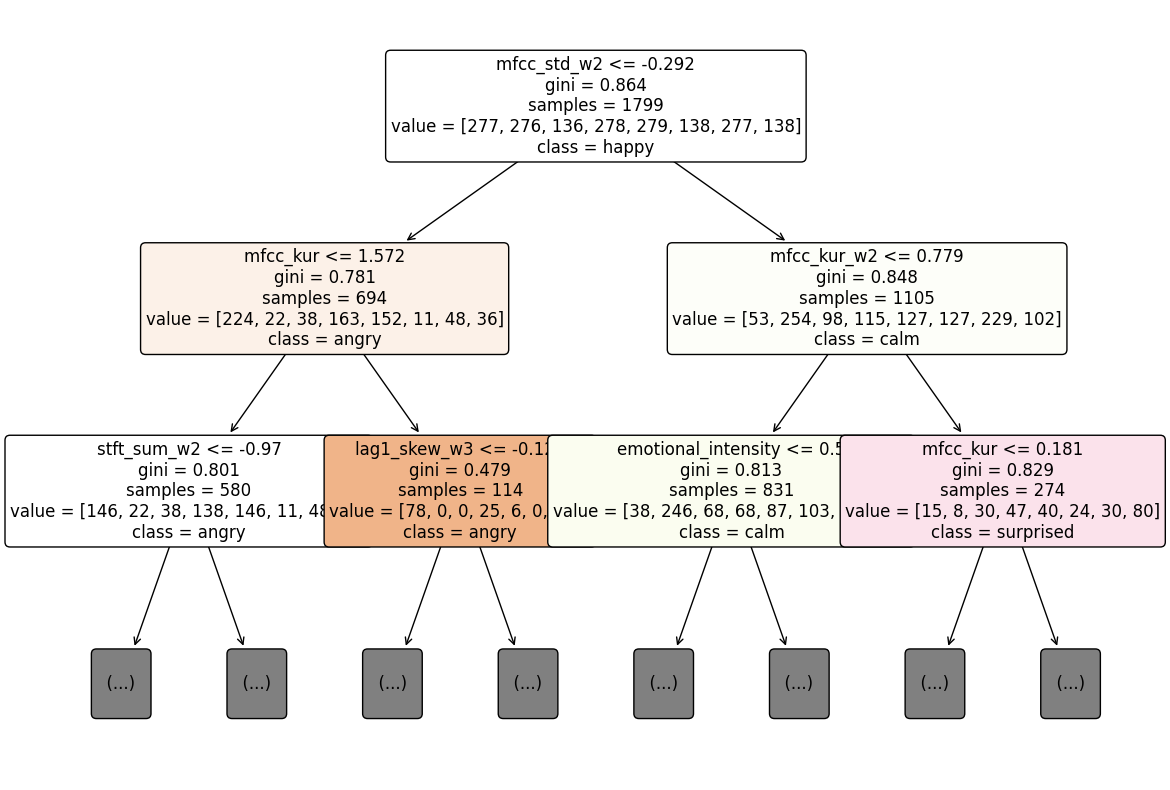

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.tree import export_graphviz
import graphviz
import pydotplus 
from IPython.display import Image
from sklearn import tree  


plt.figure(figsize=(14, 10))
plot_tree(explainer, 
          feature_names=featcat, 
          class_names=list(bb_cat.classes_), 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()


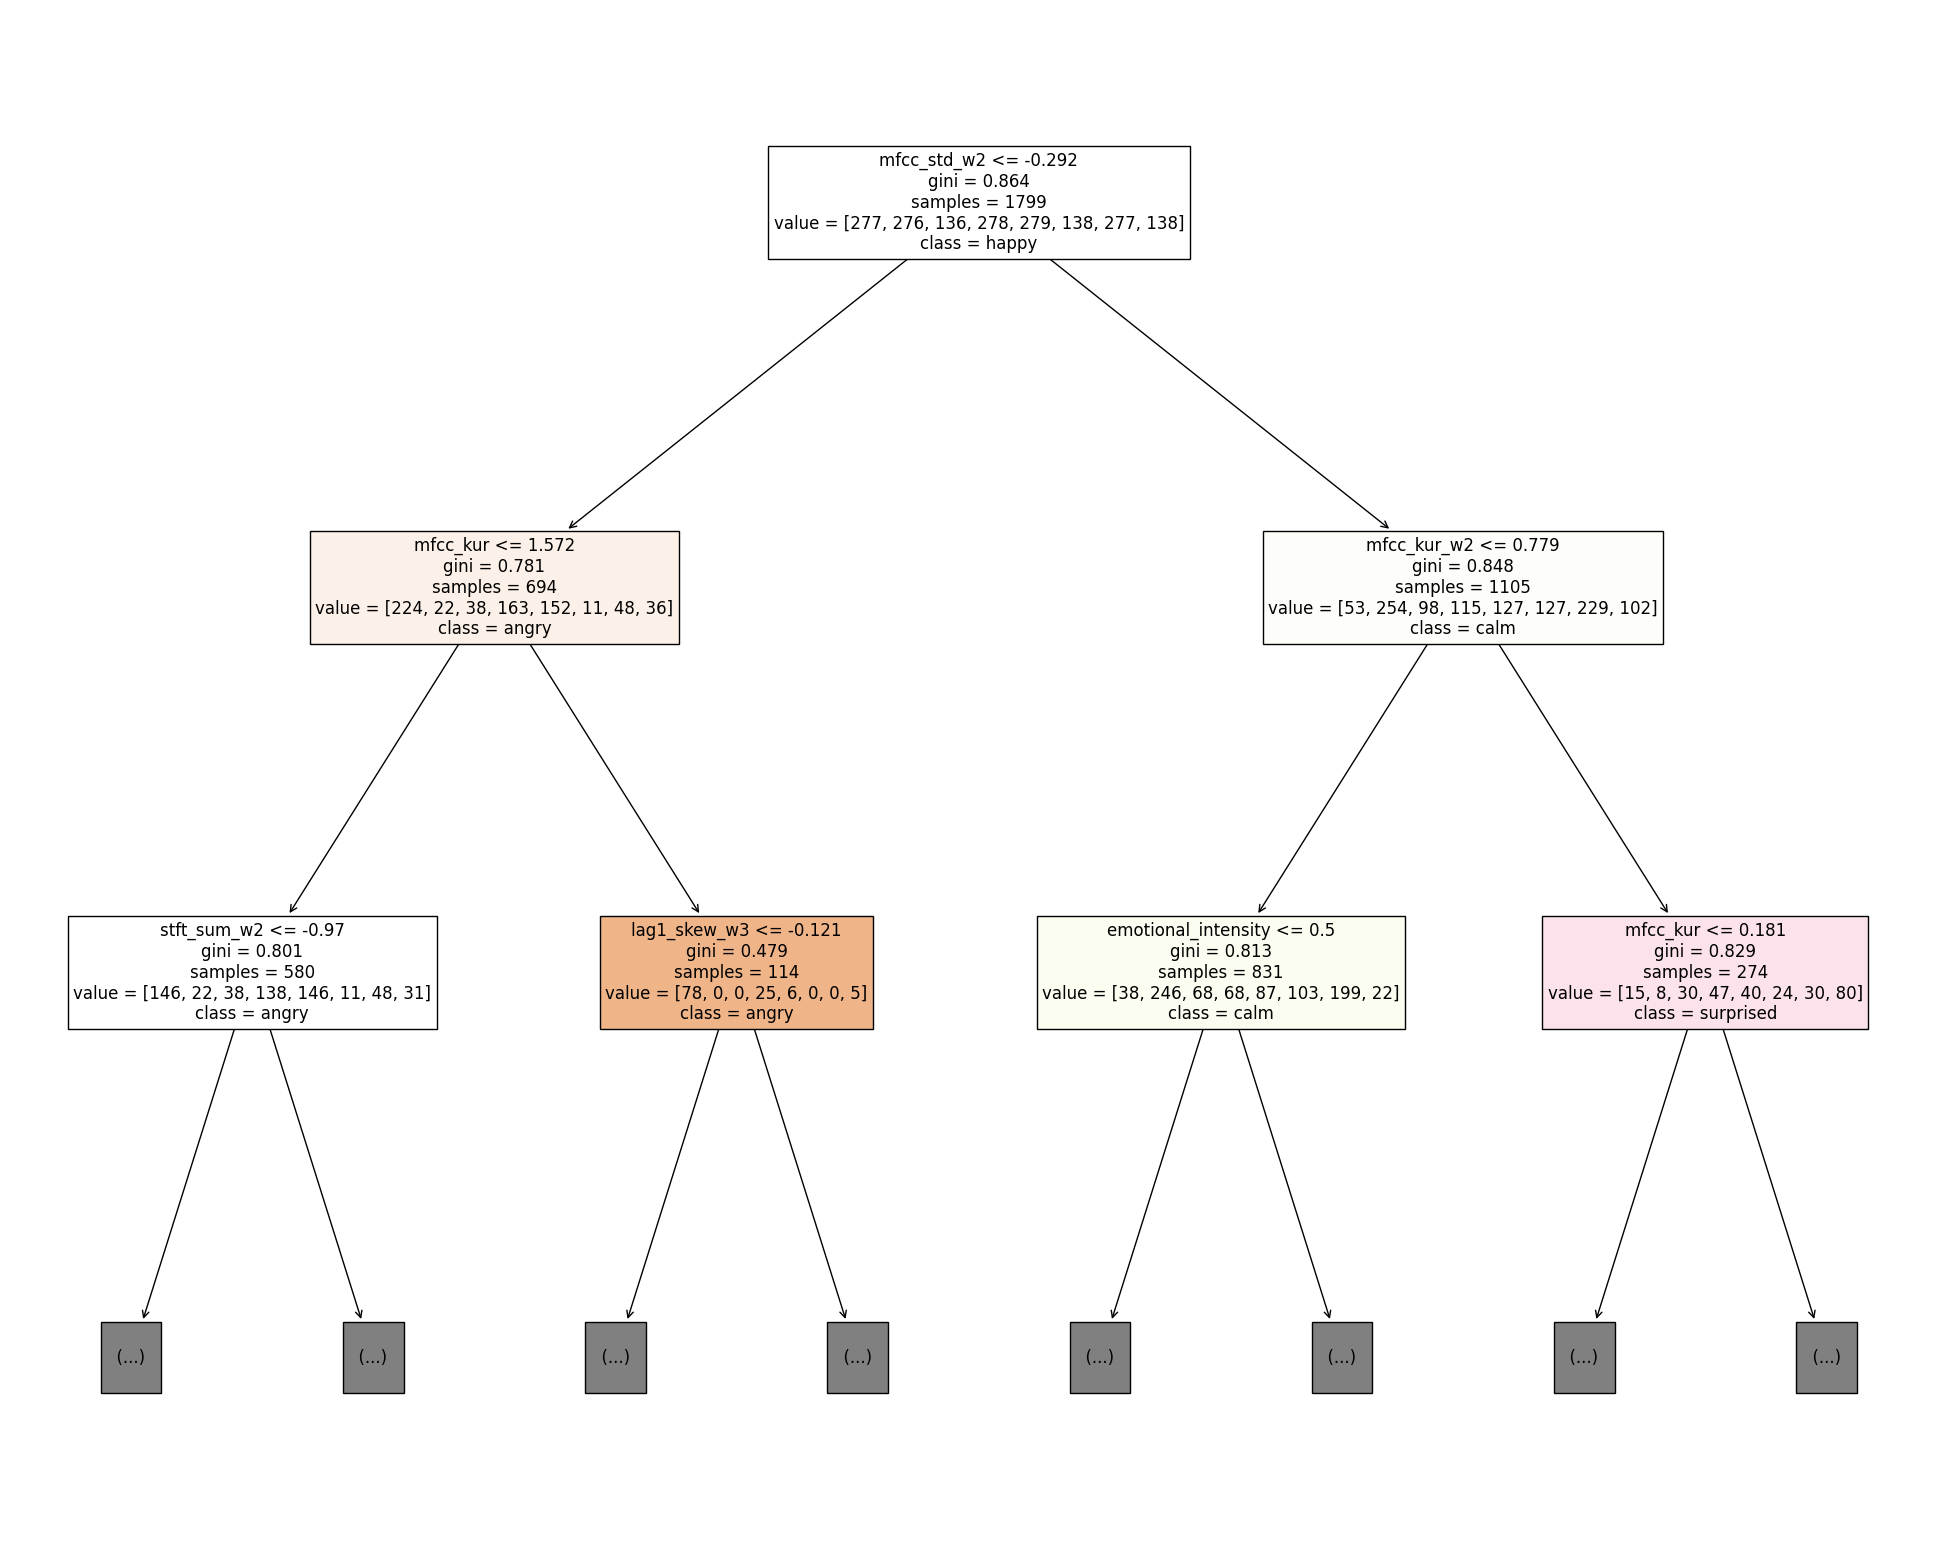

In [26]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(explainer, 
                   feature_names=featcat,  
                   class_names=list(bb_cat.classes_),
                   filled=True,
                   max_depth=2,
                   fontsize=12)
fig.savefig("decision_tree.png")